In [1]:
import os, sys
import h5py
import numpy as np
import pandas as pd
import scipy
import math as m
import cmath
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
plt.switch_backend('TkAgg')


PROJECT_CWD = r"/workspace/"
sys.path.append(PROJECT_CWD)

from my_packages.neural_network.data_generators.mixed_array_generator import MixedArrayGenerator
from my_packages.neural_network.data_generators.iterator import DataIterator

# torch import 
import torch
from torch.utils.data import TensorDataset, DataLoader

print("cuda available: ", torch.cuda.is_available())
print("number of GPUs: ",torch.cuda.device_count())
print("I am currently using device number: ", torch.cuda.current_device())
print("the device object is: ", torch.cuda.device(0))
print("the device name is: ", torch.cuda.get_device_name(0))

cuda available:  True
number of GPUs:  1
I am currently using device number:  0
the device object is:  <torch.cuda.device object at 0x7f7aef06b880>
the device name is:  NVIDIA T600 Laptop GPU


In [2]:
# data parameters
resolution=(7,7)
field_res = (21,21)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 10
probe_height = 0.3e-2
dipole_density_E = 0.2
dipole_density_H = 0.2


rmg = MixedArrayGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    probe_height=probe_height,
    dynamic_range=dynamic_range,
    f=[1e9],
    field_res=field_res,
    dipole_density_E=dipole_density_E,
    dipole_density_H=dipole_density_H
    )

data_iterator = DataIterator(rmg)


N = 100000
N_test = 1000


# # create the training data
# inputs, target = data_iterator.generate_N_data_samples(N)

# # create the test data
# inputs_test, target_test = data_iterator.generate_N_data_samples(N_test)

# # create the training and test datasets
# train_and_valid_dataset = TensorDataset(torch.from_numpy(inputs).float(), torch.from_numpy(target).float())
# print("train_dataset size: ", len(train_and_valid_dataset))
# test_dataset = TensorDataset(torch.from_numpy(inputs_test).float(), torch.from_numpy(target_test).float())

In [3]:
# save the datasets
save_dir = os.path.join(PROJECT_CWD, "NN_data", "mixed_array_data")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fullpath_train = os.path.join(save_dir, "train_and_valid_dataset.pt")
fullpath_test = os.path.join(save_dir, "test_dataset.pt")

# torch.save(train_and_valid_dataset, fullpath_train)
# torch.save(test_dataset, fullpath_test)


In [4]:
# load the data from the datasets
train_and_valid_dataset = torch.load(fullpath_train)
test_dataset = torch.load(fullpath_test)

# test
print("train_and_valid_dataset size: ", len(train_and_valid_dataset))
print("test_dataset size: ", len(test_dataset))

train_and_valid_dataset size:  100000
test_dataset size:  1000


In [5]:
# %matplotlib inline
# # inpect raw data 
# fig, ax = plt.subplots(5,3, figsize=(16,8), constrained_layout=True)
# samples, labels = train_and_valid_dataset[:5]

# for ii, (s, t) in enumerate(zip(samples, labels)):
#     rmg.plot_labeled_data(s, t, ax=ax[ii])

In [6]:
from my_packages.neural_network.datasets_and_loaders.dataset_transformers_H import H_Components_Dataset
from my_packages.neural_network.datasets_and_loaders.dataset_transformers_E import E_Components_Dataset

Hds = H_Components_Dataset(train_and_valid_dataset).scale_to_01()
Eds = E_Components_Dataset(train_and_valid_dataset).scale_to_01()

Hds_test = H_Components_Dataset(test_dataset).scale_to_01() 
Eds_test = E_Components_Dataset(test_dataset).scale_to_01()

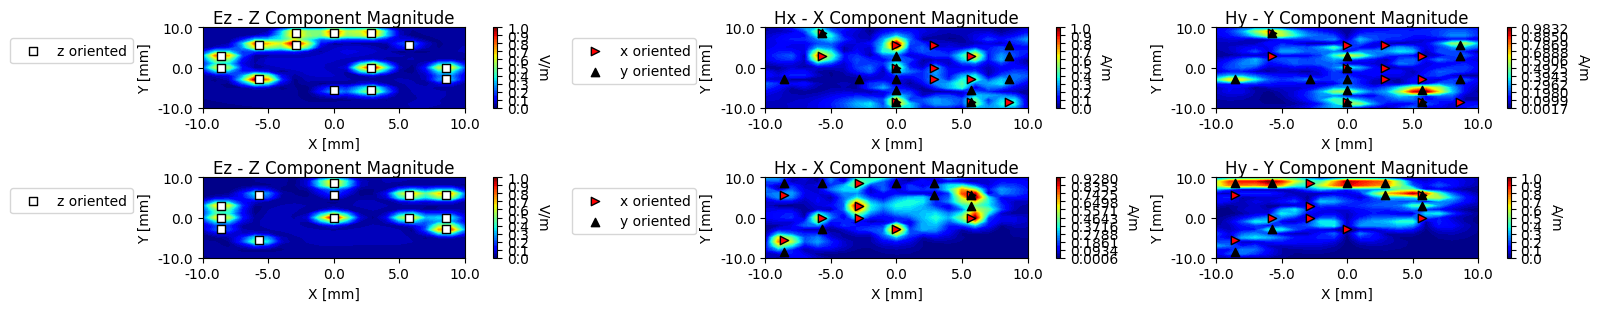

In [7]:
%matplotlib inline
NN = 2
samples, labels = Hds[:NN]
fig, ax = plt.subplots(NN, 3, figsize=(16,3), constrained_layout=True)
for ii, (s, t) in enumerate(zip(samples, labels)):
    rmg.plot_Hlabeled_data(s, t, ax=ax[ii][1:])

samples, labels = Eds[:NN]
for ii, (s, t) in enumerate(zip(samples, labels)):
    rmg.plot_Elabeled_data(s, t, ax=ax[ii][0])

In [8]:
batch_size = 64

# split into training and validation sets
train_size = int(0.8 * len(Hds))
val_size = len(Hds) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(Hds, [train_size, val_size])

print("train_dataset size: ", len(train_dataset))
print("val_dataset size: ", len(val_dataset))

# create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True ,num_workers = 4,  pin_memory=True)
test_dataloader = DataLoader(Hds_test, batch_size=batch_size, shuffle=True)

train_dataset size:  80000
val_dataset size:  20000


In [9]:
from my_packages.neural_network.model.CNN_base import CNN_Base
from torch import nn, optim
import torch.nn.functional as F
from torchsummary import summary


class CNN(CNN_Base):
    def __init__(self, in_shape, out_shape, conv_size1=32, conv_size2=64, linear_size1 = 128, loss_fn=F.mse_loss, n_layers=3):
        self.in_shape = in_shape
        self.out_shape = out_shape
        out_size = np.prod(out_shape)
        super(CNN, self).__init__(loss_fn=loss_fn)
        self.network = nn.Sequential(
            nn.Conv2d(n_layers, conv_size1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(conv_size1, conv_size2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: conv_size2 x 10 x 10
            
            nn.Flatten(),
            nn.Linear(conv_size2 * 10 * 10, linear_size1),
            nn.ReLU(),
            nn.Linear(linear_size1, out_size),
            nn.Unflatten(1, out_shape)

        )
    
    def forward(self, xb):
        return self.network(xb)
    
    def predict(self, inputs: np.ndarray):
        if isinstance(inputs, np.ndarray):
            if inputs.ndim == 3:
                inputs = np.expand_dims(inputs, axis=0)
            inputs = torch.from_numpy(inputs).float()
        return self(inputs).detach().numpy()
    
    def print_summary(self, device = "cpu"):
        return summary(self.network, input_size=self.in_shape, device=device)
    
    
    
input_shape =   (2, 21, 21)
output_shape =  (2, 7, 7)

model = CNN(input_shape, output_shape, n_layers=2)
model.print_summary()
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 21, 21]             608
              ReLU-2           [-1, 32, 21, 21]               0
            Conv2d-3           [-1, 64, 21, 21]          18,496
              ReLU-4           [-1, 64, 21, 21]               0
         MaxPool2d-5           [-1, 64, 10, 10]               0
           Flatten-6                 [-1, 6400]               0
            Linear-7                  [-1, 128]         819,328
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 98]          12,642
        Unflatten-10              [-1, 2, 7, 7]               0
Total params: 851,074
Trainable params: 851,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 3.25
Estimated T

In [10]:
# move to the GPU
from my_packages.neural_network.gpu_aux import get_default_device, to_device, DeviceDataLoader

device = get_default_device()
print("device: ", device)

# move the dataloaders to the GPU
train_dl = DeviceDataLoader(train_dataloader, device)
val_dl = DeviceDataLoader(val_dataloader, device)
test_dl = DeviceDataLoader(test_dataloader, device)


device:  cuda


In [11]:
from my_packages.neural_network.model.model_trainer import Trainer

input_shape = (2, 21, 21)
output_shape = (2, 7, 7)
conv_layer1_size = 64
conv_layer2_size = 128
linear_layer1_size = 256
loss_fn = nn.BCEWithLogitsLoss()
lr = 0.001
patience = 3
lr_dampling_factor = 0.2
opt_func = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

model = CNN(
    input_shape,
    output_shape, 
    n_layers=2,
    conv_size1=conv_layer1_size, 
    conv_size2=conv_layer2_size, 
    linear_size1=linear_layer1_size,
    loss_fn=loss_fn
    )

trainer = Trainer(
    model, opt_func=opt_func,
    lr=lr, patience=patience,
    lr_scheduler=scheduler, 
    scheduler_kwargs={'mode':'min', 'factor':lr_dampling_factor, 'patience':1, 
                      'verbose':True},
    model_dir="models/simple_magnetic",
    print_interval=2,
    log_to_wandb=True,
    wandb_name="CNN_larger_fully_connected"
    )


model = to_device(model, device)

model.evaluate(val_dl)


# create a dataset
n_iterations = 50

# model dir
model_dir = os.path.join(PROJECT_CWD, "models", "simple_magnetic")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

history = trainer.fit(n_iterations, train_dl, val_dl)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find = tomPC_container.
wandb: Currently logged in as: tm95mon. Use `wandb login --relogin` to force relogin


Epoch [0], train_loss: 0.1314, val_loss: 0.0570, val_acc: 0.9582
Epoch [2], train_loss: 0.0289, val_loss: 0.0285, val_acc: 0.9807
Epoch [4], train_loss: 0.0162, val_loss: 0.0213, val_acc: 0.9850
Epoch [6], train_loss: 0.0103, val_loss: 0.0191, val_acc: 0.9867
EarlyStopping counter: 1 out of 3
Epoch 00009: reducing learning rate of group 0 to 2.0000e-04.
Epoch [8], train_loss: 0.0071, val_loss: 0.0210, val_acc: 0.9863
EarlyStopping counter: 2 out of 3
Epoch [10], train_loss: 0.0012, val_loss: 0.0162, val_acc: 0.9905
EarlyStopping counter: 1 out of 3
Epoch 00012: reducing learning rate of group 0 to 4.0000e-05.
EarlyStopping counter: 2 out of 3
Epoch [12], train_loss: 0.0005, val_loss: 0.0168, val_acc: 0.9909
EarlyStopping counter: 3 out of 3
Early stopping


wandb: ERROR Control-C detected -- Run data was not synced


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint.pth'

In [ ]:
# import wandb

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
#     history = []
#     optimizer = opt_func(model.parameters(), lr)
#     for epoch in range(epochs):
#         # Training Phase 
#         model.train()
#         train_losses = []
#         for batch in train_loader:
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
#             # Log params to wandb
#             for name, param in model.named_parameters():
#                 if param.requires_grad:
#                     wandb.log({f"{name}_grad_norm": param.grad.norm(),
#                             f"{name}_grad_mean": param.grad.mean(),
#                             f"{name}_grad_std": param.grad.std(),
#                             f"{name}_grad_max": param.grad.max(),
#                             f"{name}_grad_min": param.grad.min()}, step=epoch)
#                     wandb.log({f"{name}_param_norm": param.norm(),
#                             f"{name}_param_mean": param.mean(),
#                             f"{name}_param_std": param.std(),
#                             f"{name}_param_max": param.max(),
#                             f"{name}_param_min": param.min()}, step=epoch)
#             optimizer.step()
#             optimizer.zero_grad()
            

#         # Validation phase
#         result = model.evaluate(val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
        
#         # Log accuracy and loss to wandb
#         wandb.log({"val_acc": result['val_acc'], "val_loss": result['val_loss']}, step=epoch)
        
#         if (epoch) % 10 == 0:
#             model.epoch_end(epoch, result)
#         history.append(result)
#     return history

In [ ]:
# output_shape = (2, 7, 7)
# conv_layer1_size = 32
# conv_layer2_size = 64
# linear_layer1_size = 128
# loss_fn = nn.BCEWithLogitsLoss()
# lr = 0.001
# patience = 10
# lr_dampling_factor = 0.1
# opt_func = torch.optim.Adam

# model = CNN(
#     output_shape, 
#     n_layers=2,
#     conv_size1=conv_layer1_size, 
#     conv_size2=conv_layer2_size, 
#     linear_size1=linear_layer1_size,
#     loss_fn=loss_fn)

# trainer = Trainer(
#     model, opt_func=opt_func,
#     lr=lr, patience=patience, 
#     scheduler_kwargs={'mode':'min', 'factor':lr_dampling_factor, 'patience':2, 
#                       'verbose':True})


# model = to_device(model, device)

# model.evaluate(val_dl)

{'val_loss': 0.6936355829238892, 'val_acc': 0.0}

In [ ]:

# # create a dataset
# n_iterations = 50

# # model dir
# model_dir = os.path.join(PROJECT_CWD, "models", "simple_magnetic")
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# # 2a6ac6cf8c981bd8a56480328e6affc93f086c07

# config = dict(
#     epochs=n_iterations,
#     learning_rate=lr,
#     conv_layer1_size=conv_layer1_size,
#     conv_layer2_size=conv_layer2_size,
#     linear_layer1_size=linear_layer1_size,
#     loss_fn=loss_fn.__class__.__name__,
#     opt_func=opt_func.__name__,
#     dataset_size=N,
#     test_dataset_size=N_test,
#     batch_size=batch_size)

# # increase timeout to 300s
# os.environ["WANDB__SERVICE_WAIT"] = "300"

# wrun = wandb.init(project="magnetic_dipole_inversion", entity="tm95mon", name="CNN2", config=config)
# wandb.watch(model, log="all", log_freq=50) 

# # save model 
# model_artifact = wandb.Artifact('CNN_earlystopping_lr', type='model', description='simple 21x21 -> 7x7 mangetic model only', metadata=dict(config))

# history = trainer.fit(n_iterations, train_dl, val_dl)
# # temp save of the model
# torch.save(model.state_dict(), os.path.join(model_dir, "temp.pt"))

Problem at: /tmp/ipykernel_16422/1830818724.py 26 <module>


CommError: Run initialization has timed out after 60.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [18]:
torch.save(model.state_dict(), os.path.join(model_dir, "CNN_earlystopping_lr.pt"))

wandb: Network error (TransientError), entering retry loop.


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

history = trainer.history

h = [x['val_loss'] for x in history]
acc = [x['val_acc'] for x in history]

to_device(model, 'cpu')

# Evaluate the model on the test set
with torch.no_grad():
    test_loss = 0.0
    for test_xb, test_yb in test_dataloader:
        model.eval()
        test_pred = model(test_xb)
        test_loss += loss_fn(test_pred, test_yb).item()
    
    test_loss /= len(test_dataloader)
    print('Test Loss: {:.4f}'.format(test_loss))

# Plot loss and validation loss
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4))
ax.plot(h, label='validation loss')

# ax.axhline(y=test_loss, color='r', linestyle='--', label='test loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs. Number of Training Epochs')
ax.legend()

ax1.plot(acc, label='validation accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy vs. Number of Training Epochs')
ax1.legend()

plt.show()

AttributeError: 'NoneType' object has no attribute '_log'

In [ ]:
for test_xb, test_yb in test_dataloader:
    print(test_xb.shape)
    break

torch.Size([64, 2, 21, 21])


In [ ]:
%matplotlib inline
random_H, target = rmg.generate_labeled_data()
def predict(H, threshold=0.5, output_shape =None, renormalize_to_01=False):
    # normalize H
    min_value = np.min(H)
    max_value = np.max(H)
    H = (H - min_value) / (max_value - min_value)

    H = np.expand_dims(H, axis=0)
    H = torch.from_numpy(H).float()
    with torch.no_grad():
        model.eval()
        to_device(model, "cpu")
        pred = model(H)
    pred = pred.numpy().squeeze()
    if output_shape is not None:
        pred = pred.reshape(output_shape)
    # transform to probabilities
    # clip to zero minimum
    if renormalize_to_01:
        max_value = np.max(pred)
        min_value = np.min(pred)
        prob_pred = (pred - min_value) / (max_value - min_value)
    else:
        prob_pred = pred

    binarized_pred = np.zeros_like(pred)
    binarized_pred[prob_pred > threshold] = 1
    pred = binarized_pred
    return pred, prob_pred

certainty = 0.5
prediction, pred_probability = predict(random_H, output_shape=(3,7,7), threshold=certainty)

fig, ax = plt.subplots(3,2, figsize=(9,4.5), constrained_layout=True)

# ax[1,0].pcolor(prediction[0])
rmg.plot_labeled_data(random_H, target, ax=(ax[0,0], ax[0,1]))
ax[0,0].set_title("target Hx")
ax[0,1].set_title("target Hy")
rmg.plot_labeled_data(random_H, prediction, ax=(ax[1,0], ax[1,1]))
ax[1,0].set_title("predicted Hx")
ax[1,1].set_title("predicted Hy")

x_grid, y_grid, _ = rmg.generate_r0_grid()[..., 0]
q1 = ax[2,0].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[0], vmin=0, vmax=1)
q2 = ax[2,1].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[1], vmin=0, vmax=1)
ax[2,0].set_title("probability Hx")
ax[2,1].set_title("probability Hy")
ax[2,0].set_xlabel("x [mm]")
ax[2,1].set_xlabel("x [mm]")
ax[2,0].set_ylabel("y [mm]")
ax[2,1].set_ylabel("y [mm]")
cbar = fig.colorbar(q1, ax=ax[2,0], ticks=[0, 0.5, 1], label="probability")
cbar = fig.colorbar(q2, ax=ax[2,1], ticks=[0, 0.5, 1], label="probability")

RuntimeError: Given groups=1, weight of size [32, 2, 3, 3], expected input[1, 3, 21, 21] to have 2 channels, but got 3 channels instead

In [3]:
import torch 
import os

model_dir = os.path.join(PROJECT_CWD, "models", "simple_magnetic")
model = torch.load(os.path.join(model_dir, "temp.pt"))

# save the model 
modelname = "CNN_earlystopping_lr"

torch.save(model.state_dict(), os.path.join(model_dir, modelname + ".pt"))


# save the model 
model_artifact.add_file(os.path.join(model_dir, "temp.pt"))
wandb.log_artifact(model_artifact)


NameError: name 'model_dir' is not defined

In [22]:
wandb.finish();

wandb: ERROR Error while calling W&B API: run tm95mon/magnetic_dipole_inversion/9s62mx4z was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run tm95mon/magnetic_dipole_inversion/9s62mx4z was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run tm95mon/magnetic_dipole_inversion/9s62mx4z was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run tm95mon/magnetic_dipole_inversion/9s62mx4z was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run tm95mon/magnetic_dipole_inversion/9s62mx4z was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run tm95mon/magnetic_dipole_inversion/9s62mx4z was previously created 

In [13]:
# increase waiting time to 300s
import wandb
wandb.finish();